In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['character-predictions.csv', 'character-deaths.csv', 'battles.csv']


In [2]:
import pandas as pd
import glob
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
files = glob.glob('../input/*.csv')

In [4]:
# Read the files in
for x in files:
    if x.find('battles') != -1:
        bt_df = pd.read_csv(x)
    elif x.find('-predictions') != -1:
        cp_df = pd.read_csv(x)
    else:
        cd_df = pd.read_csv(x)

In [5]:
# Check the shape for battles
bt_df.shape

(38, 25)

In [6]:
bt_df.head()

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,defender_2,defender_3,defender_4,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,summer,location,region,note
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,1.0,0.0,15000.0,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,NaN
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Baratheon,NaN,NaN,NaN,win,ambush,1.0,0.0,NaN,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,NaN
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,0.0,1.0,15000.0,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,NaN
3,Battle of the Green Fork,298,4,Robb Stark,Joffrey/Tommen Baratheon,Stark,NaN,NaN,NaN,Lannister,NaN,NaN,NaN,loss,pitched battle,1.0,1.0,18000.0,20000.0,"Roose Bolton, Wylis Manderly, Medger Cerwyn, H...","Tywin Lannister, Gregor Clegane, Kevan Lannist...",1.0,Green Fork,The Riverlands,NaN
4,Battle of the Whispering Wood,298,5,Robb Stark,Joffrey/Tommen Baratheon,Stark,Tully,NaN,NaN,Lannister,NaN,NaN,NaN,win,ambush,1.0,1.0,1875.0,6000.0,"Robb Stark, Brynden Tully",Jaime Lannister,1.0,Whispering Wood,The Riverlands,NaN


In [7]:
# Graph analysis. 
# Get these back into single king and ally columns
aka1 = bt_df[['attacker_king', 'attacker_1']]
aka2 = bt_df[['attacker_king', 'attacker_2']]
aka3 = bt_df[['attacker_king', 'attacker_3']]
aka4 = bt_df[['attacker_king', 'attacker_4']]
dkd1 = bt_df[['defender_king', 'defender_1']]
dkd2 = bt_df[['defender_king', 'defender_2']]
dkd3 = bt_df[['defender_king', 'defender_3']]
dkd4 = bt_df[['defender_king', 'defender_4']]

In [8]:
# Make a list of the df's made in previous cell
mat_list = [aka1, aka2, aka3, aka4, dkd1, dkd2, dkd3, dkd4]

In [9]:
# Change the column names
for x in mat_list:
    x.columns = ['king', 'ally']

In [10]:
# Concat the frames
bk = pd.concat(mat_list,axis=0)

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


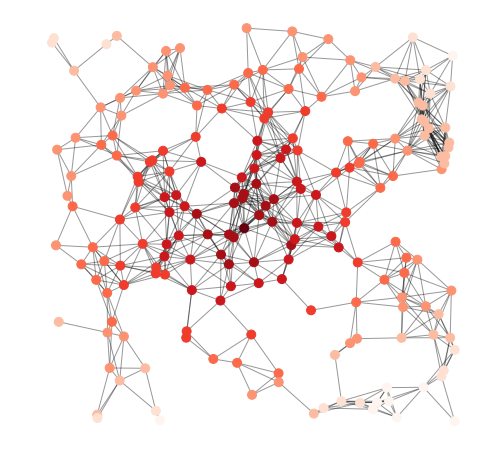

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.random_geometric_graph(200, 0.125)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, 'pos')

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()

In [12]:
# Drop the null allies, since they don't represent an alliance
bk.dropna(inplace=True)

In [13]:
# Check the shape to make sure it worked
bk.shape

(88, 2)

In [14]:
# Make a crosstab
mx_df = pd.crosstab(bk.king, bk.ally)

In [15]:
# Make a kings x allies copy
kings_x_allies = mx_df.copy()

In [16]:
# ... and an allies x kings copy, transposed.
allies_x_kings = mx_df.T.copy()

In [17]:
print(kings_x_allies.shape)
print(allies_x_kings.shape)

(6, 19)
(19, 6)


In [18]:
# Make the adjacency matrix
ally_adj = allies_x_kings.dot(kings_x_allies).copy()

In [19]:
ally_adj

ally,Baratheon,Blackwood,Bolton,Bracken,Darry,Free folk,Frey,Giants,Glover,Greyjoy,Karstark,Lannister,Mallister,Mormont,Night's Watch,Stark,Thenns,Tully,Tyrell
ally,,,,,,,,,,,,,,,,,,,
Baratheon,43,1,8,2,2,6,7,6,12,2,12,36,2,12,1,15,6,7,4
Blackwood,1,1,0,0,2,0,1,0,0,0,0,0,0,0,0,15,0,7,0
Bolton,8,0,16,4,0,0,12,0,0,4,0,72,4,0,0,0,0,0,8
Bracken,2,0,4,1,0,0,3,0,0,1,0,18,1,0,0,0,0,0,2
Darry,2,2,0,0,4,0,2,0,0,0,0,0,0,0,0,30,0,14,0
Free folk,6,0,0,0,0,1,0,1,2,0,2,0,0,2,0,0,1,0,0
Frey,7,1,12,3,2,0,10,0,0,3,0,54,3,0,0,15,0,7,6
Giants,6,0,0,0,0,1,0,1,2,0,2,0,0,2,0,0,1,0,0
Glover,12,0,0,0,0,2,0,2,4,0,4,0,0,4,0,0,2,0,0


In [20]:
G = nx.from_numpy_matrix(ally_adj.values)
G = nx.relabel_nodes(G, dict(enumerate(ally_adj.columns)))

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


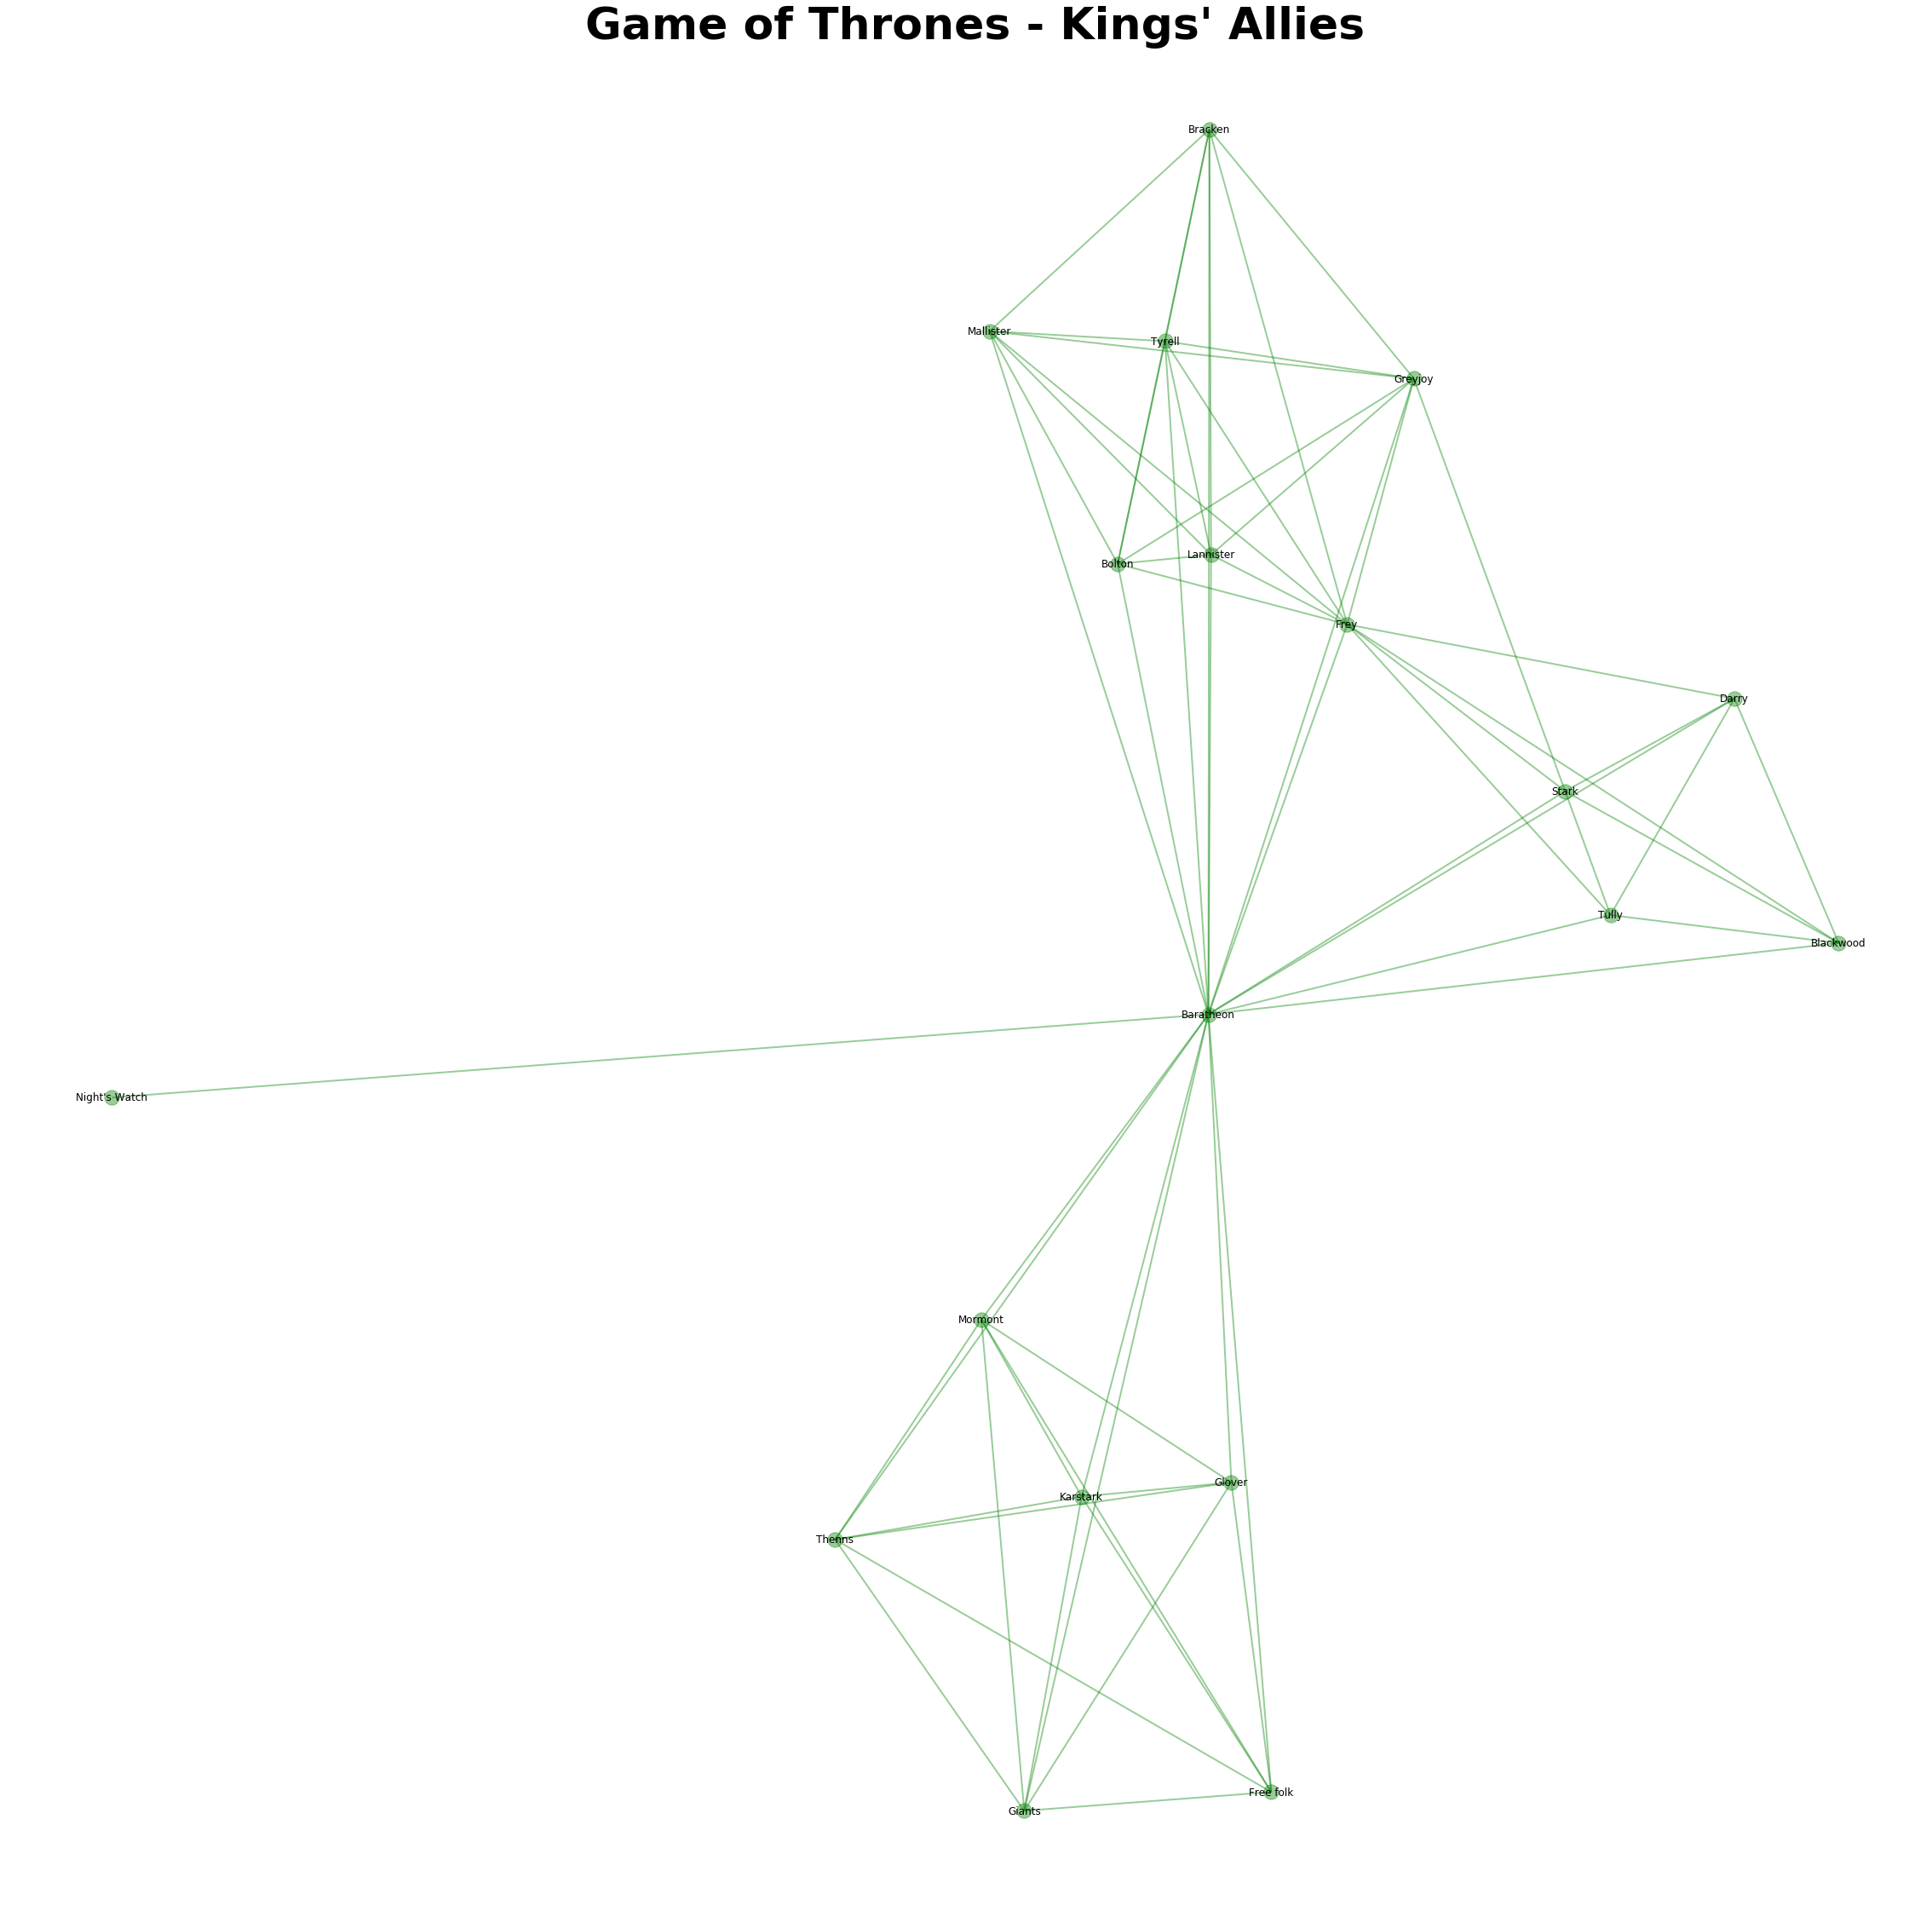

In [21]:
plt.figure(figsize=(40,40))
pos=nx.spring_layout(G, iterations=500, scale=5, k=.3)
nx.draw_networkx_labels(G,pos,fontsize=30)
font = {'fontname'   : 'Helvetica',
            'color'      : 'k',
            'fontweight' : 'bold',
            'fontsize'   : '52'}
plt.title("Game of Thrones - Kings' Allies", font)


nx.draw_networkx_nodes(G,pos,node_color='g',alpha=0.4)
nx.draw_networkx_edges(G,pos,alpha=0.4,node_size=100,width=2,edge_color='g')
plt.axis('off')
plt.show()

In [22]:
# Determine centrality for an ordered list of who best has their king's back during a battle
centrality=nx.eigenvector_centrality(G)

In [23]:
loyalty_list = []
for node in centrality:
    loyalty_list.append((node,centrality[node]))
    
sorted_loyalty_list = loyalty_list.sort(key=lambda x: x[1])

In [24]:
# Interesting. The Kingslayer is at the top of this list.
sorted(loyalty_list, key=lambda x: x[1], reverse=True)

[('Baratheon', 0.4449098772450081),
 ('Frey', 0.34149442086462917),
 ('Greyjoy', 0.28756044111024315),
 ('Bolton', 0.26606097948752333),
 ('Bracken', 0.26606097948752333),
 ('Lannister', 0.26606097948752333),
 ('Mallister', 0.26606097948752333),
 ('Tyrell', 0.26606097948752333),
 ('Stark', 0.1942805340645974),
 ('Blackwood', 0.1624585861665946),
 ('Darry', 0.1624585861665946),
 ('Tully', 0.1624585861665946),
 ('Free folk', 0.14652381500012449),
 ('Giants', 0.14652381500012449),
 ('Glover', 0.14652381500012449),
 ('Karstark', 0.14652381500012449),
 ('Mormont', 0.14652381500012449),
 ('Thenns', 0.14652381500012449),
 ("Night's Watch", 0.05536115587691574)]

In [25]:
# Now, let's switch and see what the king look like
king_adj = kings_x_allies.dot(allies_x_kings).copy()

In [26]:
king_adj.shape

(6, 6)

In [27]:
K = nx.from_numpy_matrix(king_adj.values)
K = nx.relabel_nodes(K, dict(enumerate(king_adj.columns)))

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


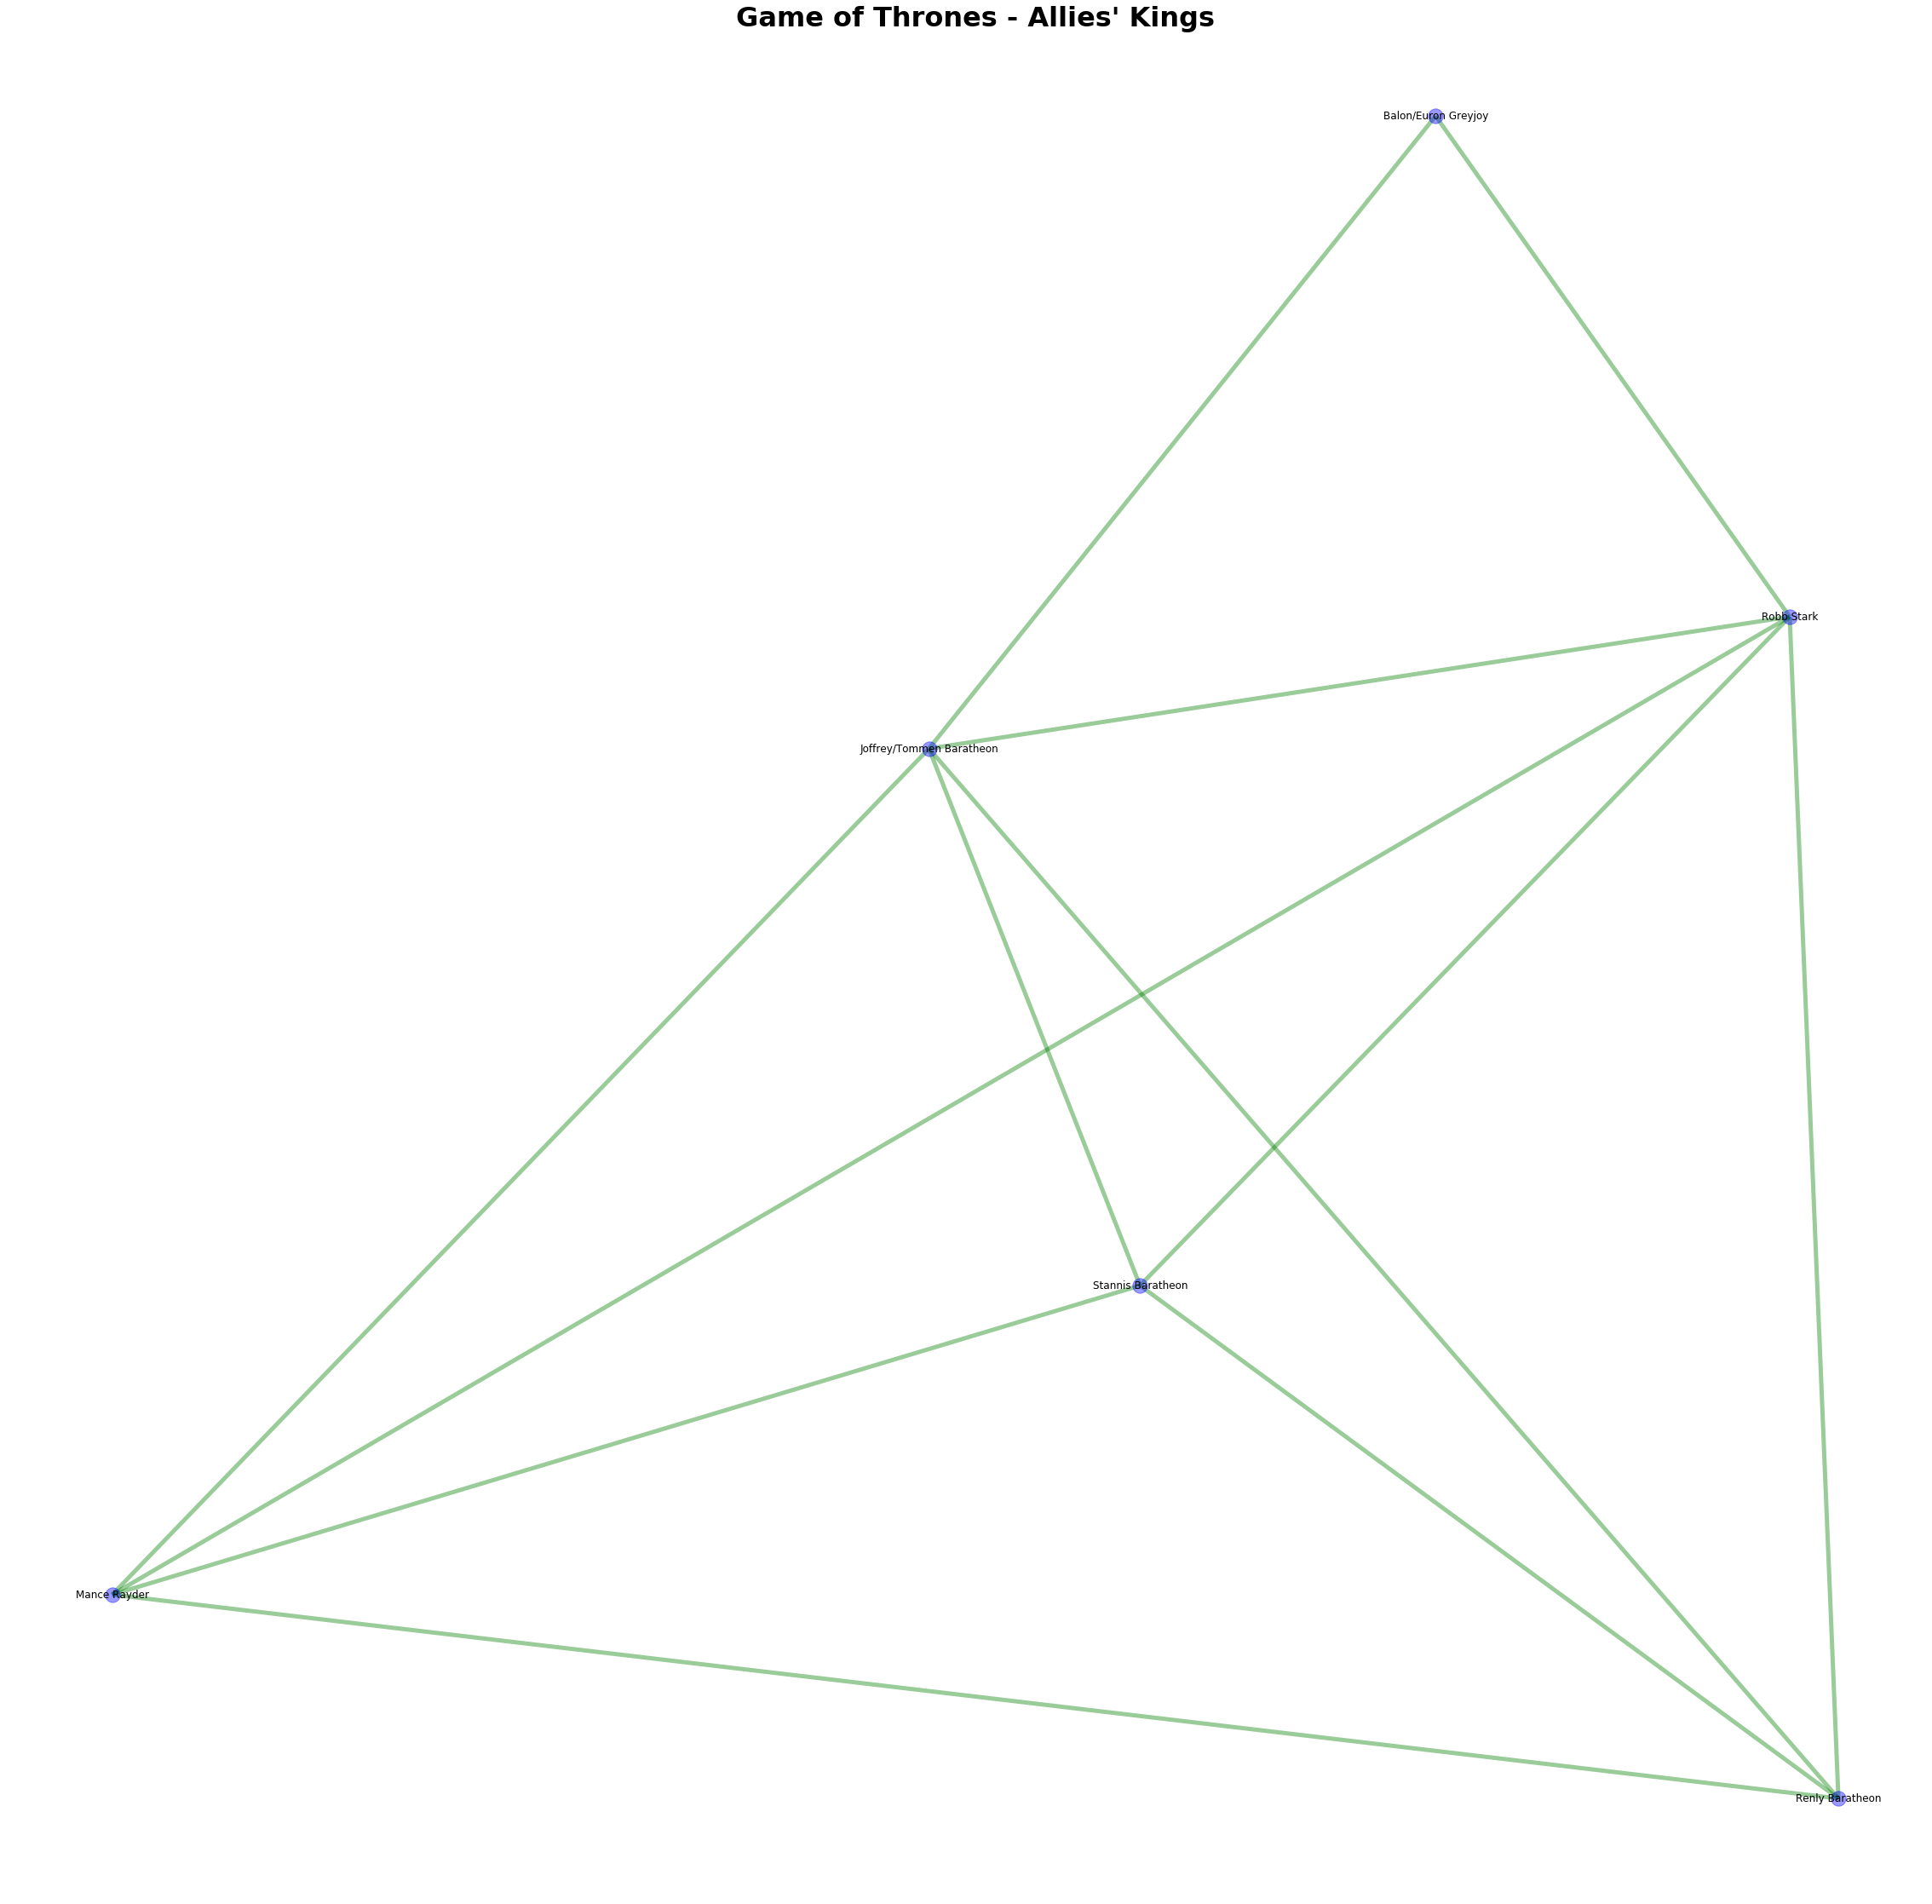

In [28]:
plt.figure(figsize=(40,40))
pos=nx.spring_layout(K, iterations=500, scale=5, k=.3)
nx.draw_networkx_labels(K,pos,fontsize=28)
font = {'fontname'   : 'Helvetica',
            'color'      : 'k',
            'fontweight' : 'bold',
            'fontsize'   : 32}
plt.title("Game of Thrones - Allies' Kings", font)


nx.draw_networkx_nodes(K,pos,node_color='b',alpha=0.4)
nx.draw_networkx_edges(K,pos,alpha=0.4,node_size=250,width=5,edge_color='g')
plt.axis('off')
plt.show()

In [29]:
centrality=nx.eigenvector_centrality(K)

In [30]:
king_list = []
for node in centrality:
    king_list.append((node,centrality[node]))
    
sorted_king_list = king_list.sort(key=lambda x: x[1])

In [31]:
# And now for the sorted list of kings
sorted(king_list, key=lambda x: x[1], reverse=True)

[('Joffrey/Tommen Baratheon', 0.4611372761849126),
 ('Robb Stark', 0.4611372761849126),
 ('Mance Rayder', 0.41893468327003863),
 ('Renly Baratheon', 0.41893468327003863),
 ('Stannis Baratheon', 0.41893468327003863),
 ('Balon/Euron Greyjoy', 0.21951313966552505)]

/opt/conda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


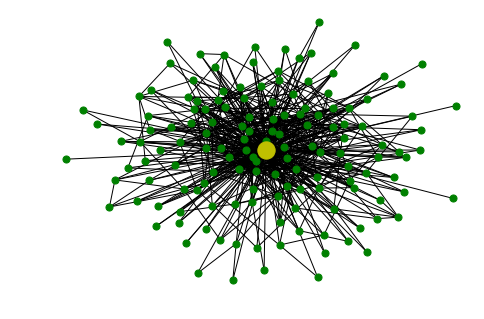

In [32]:
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx

if __name__ == '__main__':
    # Create a BA model graph
    n = 1000
    m = 8
    G = nx.generators.barabasi_albert_graph(n, m)
    #G = nx.random_geometric_graph(n, m)
    # find node with largest degree
    node_and_degree = G.degree()
    (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
    # Create ego graph of main hub
    hub_ego = nx.ego_graph(G, largest_hub)
    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='g', node_size=50, with_labels=False)
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='y')
    plt.show()